# References

- Vectice Documentation: https://docs.vectice.com/
- Vectice API Documentation: https://api-docs.vectice.com/

## We assume in this exercise that we want to retrain the model because the variable 'postal code' was left accidentally inside our initial modeling dataset

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Install the latest Vectice Python client library

In [4]:
%pip install --q vectice -U
%pip install category_encoders


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder

## Get started by connecting to Vectice

You can learn more about the `Connection` object in the [documentation](https://api-docs.vectice.com/reference/vectice/connection/)

In [27]:
import vectice as vect

vec = vect.connect(config="My-token.json") # Put your own token as explained in the Tutorial 

VECTICE_API_ENDPOINT is deprecated and will be removed in 23.3.1.0, please use VECTICE_HOST instead.
Welcome, bdaversa. You`re now successfully connected to Vectice.

To access your personal workspace, use connection.my_workspace
To access a specific workspace, use connection.workspace(Workspace ID)
To get a list of workspaces you can access and their IDs, use connection.list_workspaces()

If you are using a notebook you can call the help by using a Vectice returned object with the builtin notebook "?":
>> connection?

If you are using an IDE you can call the help() method on any object returned by Vectice:
>> help(connection)

For quick access to your default workspace in the Vectice web app, visit:
https://qa.vectice.com/browse/workspace/WSP-309


## Specify which project phase you want to document
In Vectice UI, navigate to your personal workspace inside your default Tutorial project go to the Modeling Retraining phase you just created and copy paste your Phase Id below.

In [30]:
phase = vec.phase("PHA-5859") # Put your own Modeling Retraining phase ID

Phase 'Modeling Retraining' successfully retrieved."

For quick access to the Phase in the Vectice web app, visit:
https://qa.vectice.com/browse/phase/PHA-5859


## Next we are going to create an iteration
An iteration allows you to organize your work in repeatable sequences of steps. You can have multiple iteration within a phase

In [31]:
model_iteration = phase.create_iteration()

New Iteration number '1' created.

For quick access to the Iteration in the Vectice web app, visit:
https://qa.vectice.com/browse/iteration/ITR-2258


## Retrieve your cleaned Dataset previously created in phase Data Preparation for your lineage
You can retrieve a variety of Vectice Objects with the `browse('VECTICE-ID')` method. Namely, Phases, Iterations, Datasets, Models etc

In [32]:
cleaned_ds = vec.browse("DTS-3124") #Get the ID of your Clean Dataset created in the Data Preparation phase

Dataset 'ProductSales Cleaned' successfully retrieved."

For quick access to the Dataset in the Vectice web app, visit:
https://qa.vectice.com/browse/dataset/DTS-3124


## Push a dataset

Use the following code block to create a local datset we assume that the dataset contains new Q2 Data and we already cleaned it in the previous phases

In [33]:
df = pd.read_csv("https://raw.githubusercontent.com/vectice/GettingStarted/23.2.4.1-Tutorial_update/23.2/tutorial/ProductSales%20Cleaned.csv")
df.head()

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,others,others,42420,South,Furniture,Bookcases,261.960,2,0.0,41.9136
1,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.620,2,0.0,6.8714
2,Standard Class,Consumer,United States,others,Florida,33311,South,Office Supplies,Storage,22.368,2,0.2,2.5164
3,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Furniture,Furnishings,48.860,7,0.0,14.1694
4,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Office Supplies,Art,7.280,4,0.0,1.9656


In [34]:
X = df.drop(["Sales", "Postal Code"],axis=1)
y = df["Sales"]
print(X.shape)
print(y.shape)

(7994, 11)
(7994,)


In [35]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Save the modeling train test split datasets as csv files
train_df = X_train.copy()
test_df = X_test.copy()

train_df["Sales"] = y_train
test_df["Sales"] = y_test

train_df.to_csv("train dataset.csv", index=False)
test_df.to_csv("test dataset.csv", index=False)

### Register dataset metadata and statistics
Register dataset metadata and statistics to Vectice by passing the file resource path and a `Pandas.DataFrame`

In [37]:
train_ds = vect.FileResource(paths="train dataset.csv", dataframes=train_df)
test_ds = vect.FileResource(paths="test dataset.csv", dataframes=test_df)

File: train dataset.csv wrapped successfully.
File: test dataset.csv wrapped successfully.


In [38]:
modeling_dataset = vect.Dataset.modeling(
        name="ProductSales Modeling",
        training_resource=train_ds,
        testing_resource=test_ds, 
        derived_from=cleaned_ds,
    )

## Push the Dataset
A new version will be triggered

In [39]:
model_iteration.step_model_input_data = modeling_dataset

New Version: 'Version 2' of Dataset: 'ProductSales Modeling' added to Step: Model Input Data
Attachments: None
Link to Step: https://qa.vectice.com/browse/iteration/ITR-2258



### Retrain a Ridge regressor as competitor

In [40]:
model = make_pipeline(OneHotEncoder(use_cat_names=True),
                     Ridge())
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Ship Mode', 'Segment', 'Country', 'City',
                                     'State', 'Region', 'Category',
                                     'Sub-Category'],
                               use_cat_names=True)),
                ('ridge', Ridge())])

In [41]:
# Making Prediction with the training data
y_train_pred = model.predict(X_train)
#Evaluating the model 
mae_train=mean_absolute_error(y_train, y_train_pred)
print(round(mae_train,2))

59.34


In [42]:
# Making Prediction with the training data
y_test_pred = model.predict(X_test)
#Evaluating the model 
mae_test = mean_absolute_error(y_test, y_test_pred)
print(round(mae_test,2))

63.37


/Users/bryandaversa/Vectice/GettingStarted/.venv/lib/python3.9/site-packages/category_encoders/utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


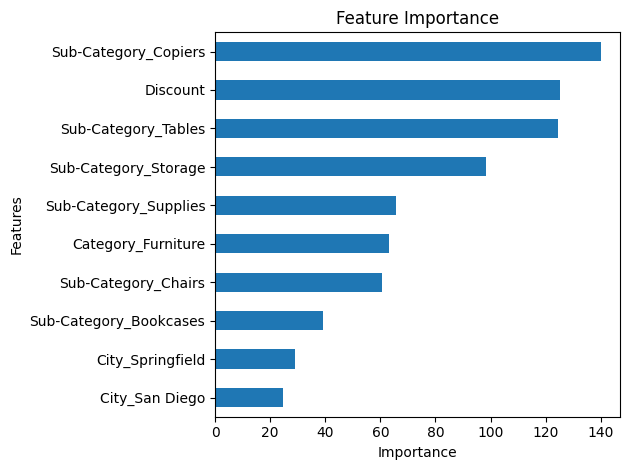

In [43]:
features = model.named_steps["onehotencoder"].get_feature_names()
importance = model.named_steps["ridge"].coef_

feat_imf = pd.Series(importance, index=features).sort_values()

feat_imf.tail(10).plot(kind="barh")
plt.ylabel("Features")
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.savefig("Feature Importance.png")

## Push a trained model with an attachment

Then we push a trained model to Vectice using the `Vectice.Model()` object.

In [44]:
vect_model = vect.Model(library="scikit-learn", technique="Ridge Regression", metrics={"mae_train": round(mae_train,2), "mae_test": round(mae_test,2)}, 
                        properties=model.named_steps, predictor=model, derived_from=modeling_dataset, attachments="Feature Importance.png")

## Add the second model to the the step

You can add multiple models to a single step by using the `+=` operator.

In [45]:
model_iteration.step_build_model += vect_model

Model Pipeline successfully attached to Model(name='scikit-learn Ridge Regression model', version='Version 2').
New Version: 'Version 2' of Model: 'scikit-learn Ridge Regression model' added to Step: Build Model
Attachments: Feature Importance.png
Link to Step: https://qa.vectice.com/browse/iteration/ITR-2258



## Add a comment 

Passing a `string` to a step will add a comment.

In [46]:
# Select the model to be staged
model_iteration.step_model_validation = f"Model passed acceptance criteria\nMAE Train: {round(mae_train,2)}\nMAE Test: {round(mae_test,2)}"

Added Comment to Step: Model Validation

Link to Step: https://qa.vectice.com/browse/iteration/ITR-2258



In [47]:
model_iteration.complete()

Iteration with index 1 completed.

For quick access to the Iteration in the Vectice web app, visit:
https://qa.vectice.com/browse/iteration/ITR-2258


✴ You can view your registered assets and comments in the UI by clicking the links in the output messages..